In [ ]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


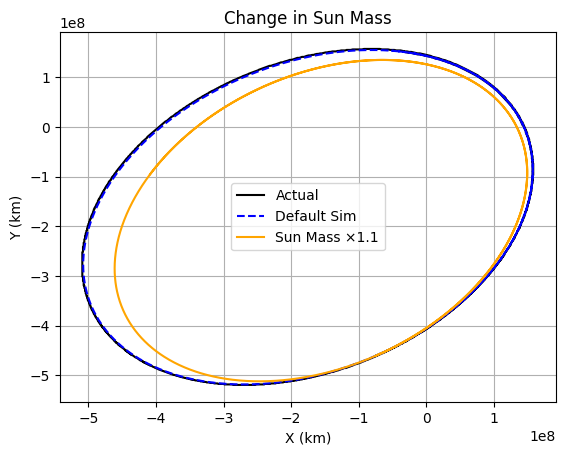

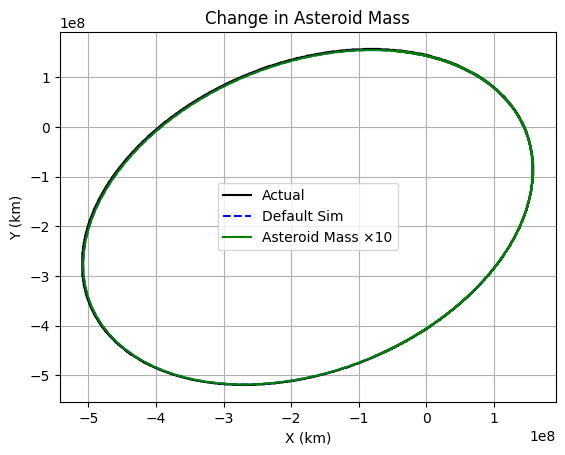

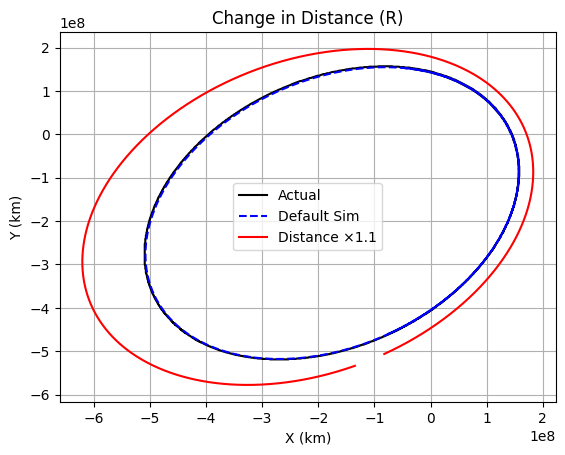

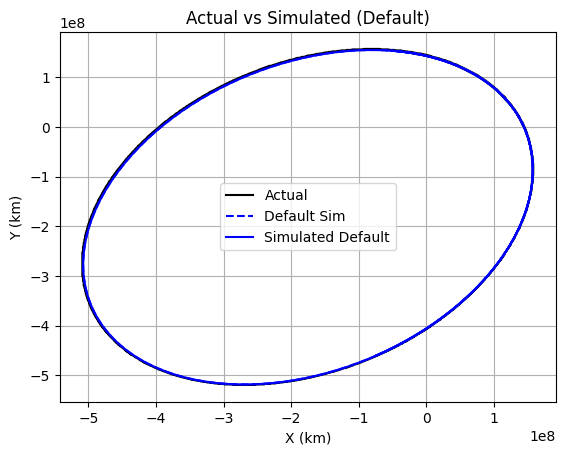

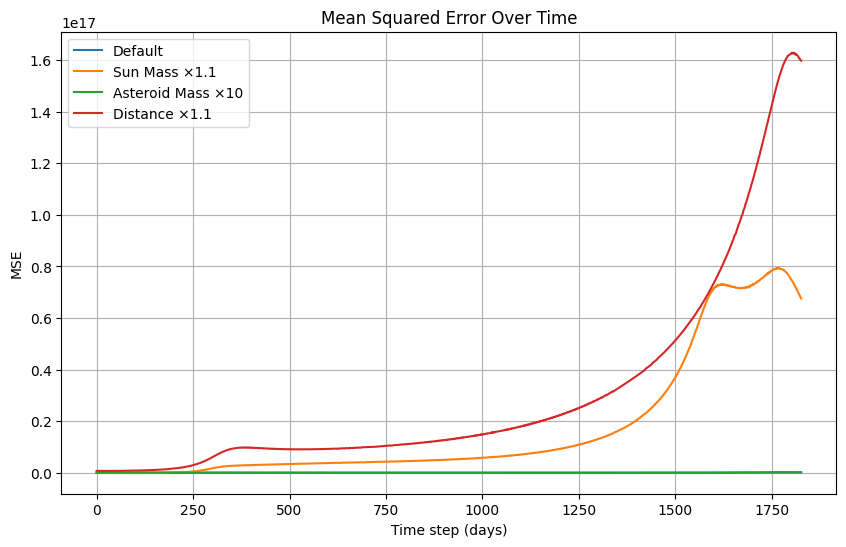

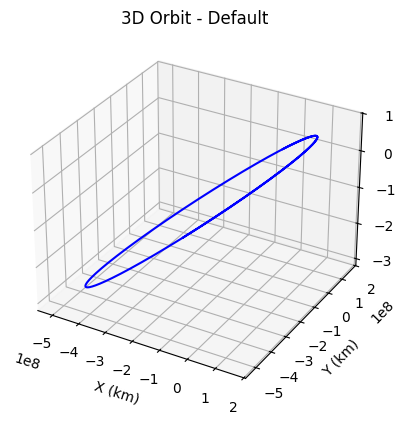

3D orbit animation saved as orbit_3d.mp4


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

# Loading and preprocessing data
df = pd.read_csv('/content/horizons_results 1.csv', skiprows=1)
df.columns = ['JDTDB', 'Date', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']
df = df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ']].apply(pd.to_numeric, errors='coerce').dropna()

positions = df[['X', 'Y', 'Z']].values
velocities = df[['VX', 'VY', 'VZ']].values

x, y, z = positions[0]
vx, vy, vz = velocities[0]
dt = 86400.0
n_steps = len(df)

G_default = 6.67430e-20
m_sun_default = 1.9885e30
m_ast_default = 1e12

# Simulation function
def simulate_orbit(G=G_default, m_sun=m_sun_default, m_ast=m_ast_default, x0=None, y0=None, z0=None):
    x_a = x0 if x0 is not None else x
    y_a = y0 if y0 is not None else y
    z_a = z0 if z0 is not None else z
    vx_a, vy_a, vz_a = vx, vy, vz
    traj = []
    for _ in range(n_steps):
        r = np.sqrt(x_a**2 + y_a**2 + z_a**2)
        ax = -G * m_sun * x_a / r**3
        ay = -G * m_sun * y_a / r**3
        az = -G * m_sun * z_a / r**3
        vx_a += ax * dt
        vy_a += ay * dt
        vz_a += az * dt
        x_a += vx_a * dt
        y_a += vy_a * dt
        z_a += vz_a * dt
        traj.append([x_a, y_a, z_a])
    return np.array(traj)

# Simulations
sim_default = simulate_orbit()
sim_sun_heavy = simulate_orbit(m_sun=m_sun_default * 1.1)
sim_ast_heavy = simulate_orbit(m_ast=m_ast_default * 10)
sim_dist_scaled = simulate_orbit(x0=x * 1.1, y0=y * 1.1, z0=z * 1.1)

# Saving 2D plots and computing MSE
def plot_and_save(title, sim, label, color, filename):
    plt.figure()
    plt.plot(positions[:, 0], positions[:, 1], 'k', label='Actual')
    plt.plot(sim_default[:, 0], sim_default[:, 1], 'b--', label='Default Sim')
    plt.plot(sim[:, 0], sim[:, 1], color=color, label=label)
    plt.title(title)
    plt.xlabel("X (km)"); plt.ylabel("Y (km)")
    plt.legend(); plt.grid()
    plt.savefig(f"/content/{filename}.png")
    plt.show()

# 4 key plots
plot_and_save("Change in Sun Mass", sim_sun_heavy, "Sun Mass ×1.1", "orange", "sun_mass")
plot_and_save("Change in Asteroid Mass", sim_ast_heavy, "Asteroid Mass ×10", "green", "ast_mass")
plot_and_save("Change in Distance (R)", sim_dist_scaled, "Distance ×1.1", "red", "dist_scaled")
plot_and_save("Actual vs Simulated (Default)", sim_default, "Simulated Default", "blue", "actual_vs_sim")

# MSE Plots
def plot_mse(actual, sims, labels):
    plt.figure(figsize=(10, 6))
    for sim, label in zip(sims, labels):
        mse = np.mean((actual - sim)**2, axis=1)
        plt.plot(mse, label=label)
    plt.title("Mean Squared Error Over Time")
    plt.xlabel("Time step (days)")
    plt.ylabel("MSE")
    plt.legend(); plt.grid()
    plt.savefig("/content/mse_plot.png")
    plt.show()

plot_mse(positions, [sim_default, sim_sun_heavy, sim_ast_heavy, sim_dist_scaled],
         ["Default", "Sun Mass ×1.1", "Asteroid Mass ×10", "Distance ×1.1"])

# 3D plot
def plot_3d_orbit(sim_data, title, color):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sim_data[:, 0], sim_data[:, 1], sim_data[:, 2], color=color)
    ax.set_title(title)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_zlabel("Z (km)")
    plt.savefig(f"/content/{title.replace(' ', '_')}_3d.png")
    plt.show()

plot_3d_orbit(sim_default, "3D Orbit - Default", 'blue')

# Animation of orbit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np

def animate_orbit_3d(sim_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Setuping axes limits
    ax.set_xlim3d(np.min(sim_data[:, 0]), np.max(sim_data[:, 0]))
    ax.set_ylim3d(np.min(sim_data[:, 1]), np.max(sim_data[:, 1]))
    ax.set_zlim3d(np.min(sim_data[:, 2]), np.max(sim_data[:, 2]))

    ax.set_title("3D Animated Orbit - Asteroid 2024 YR4")
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_zlabel("Z (km)")

    line, = ax.plot([], [], [], color='blue', lw=2)
    point, = ax.plot([], [], [], 'ro')

    def update(i):
        line.set_data(sim_data[:i+1, 0], sim_data[:i+1, 1])
        line.set_3d_properties(sim_data[:i+1, 2])
        point.set_data([sim_data[i, 0]], [sim_data[i, 1]])
        point.set_3d_properties([sim_data[i, 2]])
        return line, point

    ani = FuncAnimation(fig, update, frames=len(sim_data), interval=30, blit=True)
    ani.save("/content/orbit_3d.mp4", writer=FFMpegWriter(fps=30))
    plt.close()
    print("3D orbit animation saved as orbit_3d.mp4")


animate_orbit_3d(sim_default)


Summary Statistics:

                  X             Y             Z           VX           VY  \
count  1.827000e+03  1.827000e+03  1.827000e+03  1827.000000  1827.000000   
mean  -2.006362e+08 -2.606284e+08 -1.239392e+07     0.271001     3.878146   
std    2.379168e+08  2.175520e+08  1.439224e+07    13.910241    14.938021   
min   -5.090000e+08 -5.190000e+08 -3.100000e+07   -36.900000   -13.500000   
25%   -4.410000e+08 -4.540000e+08 -2.690000e+07    -5.910000    -9.265000   
50%   -2.260000e+08 -3.180000e+08 -1.400000e+07     5.420000    -0.246000   
75%    3.290000e+07 -8.290000e+07  1.680000e+06    11.300000    14.250000   
max    1.580000e+08  1.570000e+08  9.450000e+06    13.000000    36.500000   

                VZ            RG           RR  
count  1827.000000  1.827000e+03  1827.000000  
mean      0.022839  4.297811e+08    -1.984168  
std       0.839675  1.665271e+08     9.944279  
min      -2.210000  1.260000e+08   -16.700000  
25%      -0.361000  2.915000e+08   -11.000000

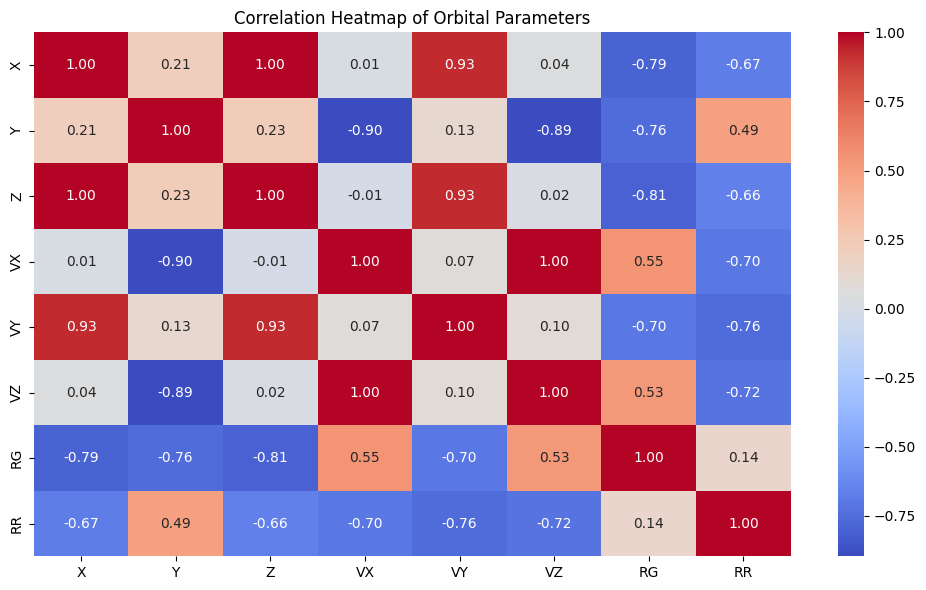

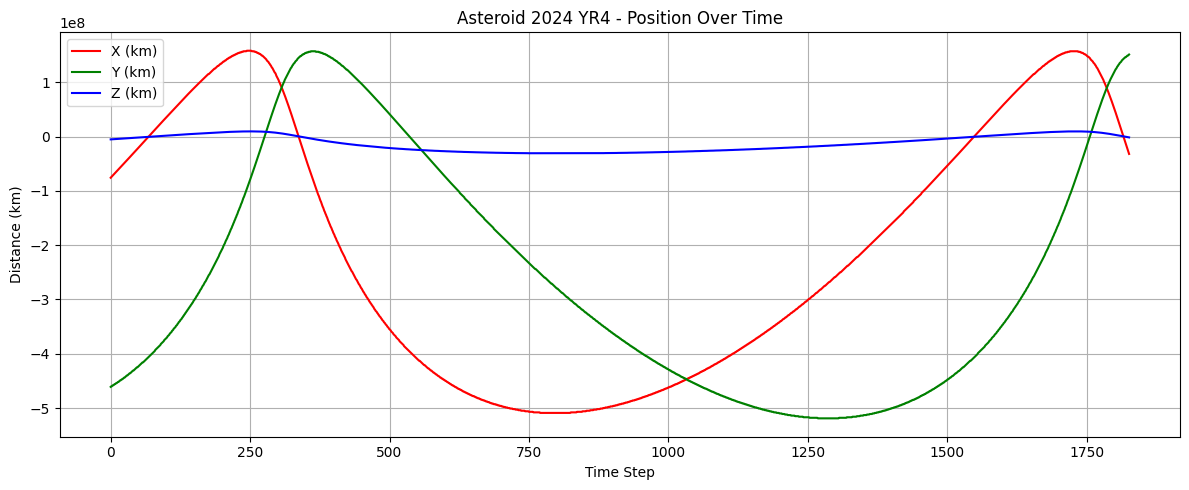

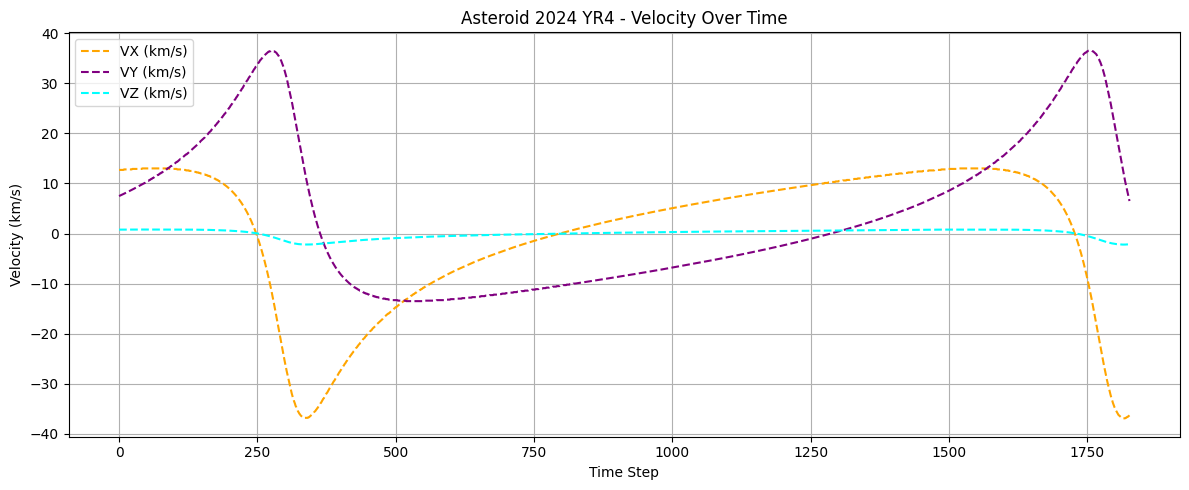

In [ ]:
# Exploratory Data Analysis (EDA)

# Required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading and cleaning data
df_eda = pd.read_csv('/content/horizons_results 1.csv', skiprows=1)
df_eda.columns = ['JDTDB', 'Date', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']
df_eda = df_eda[['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'RG', 'RR']].apply(pd.to_numeric, errors='coerce').dropna()

# Summary statistics
print("Summary Statistics:\n")
print(df_eda.describe())

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_eda.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Orbital Parameters")
plt.tight_layout()
plt.savefig("/content/eda_correlation_heatmap.png")
plt.show()

# Position over time
plt.figure(figsize=(12, 5))
plt.plot(df_eda['X'], label='X (km)', color='red')
plt.plot(df_eda['Y'], label='Y (km)', color='green')
plt.plot(df_eda['Z'], label='Z (km)', color='blue')
plt.title("Asteroid 2024 YR4 - Position Over Time")
plt.xlabel("Time Step")
plt.ylabel("Distance (km)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("/content/eda_position_over_time.png")
plt.show()

# Velocity over time
plt.figure(figsize=(12, 5))
plt.plot(df_eda['VX'], label='VX (km/s)', linestyle='--', color='orange')
plt.plot(df_eda['VY'], label='VY (km/s)', linestyle='--', color='purple')
plt.plot(df_eda['VZ'], label='VZ (km/s)', linestyle='--', color='cyan')
plt.title("Asteroid 2024 YR4 - Velocity Over Time")
plt.xlabel("Time Step")
plt.ylabel("Velocity (km/s)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("/content/eda_velocity_over_time.png")
plt.show()


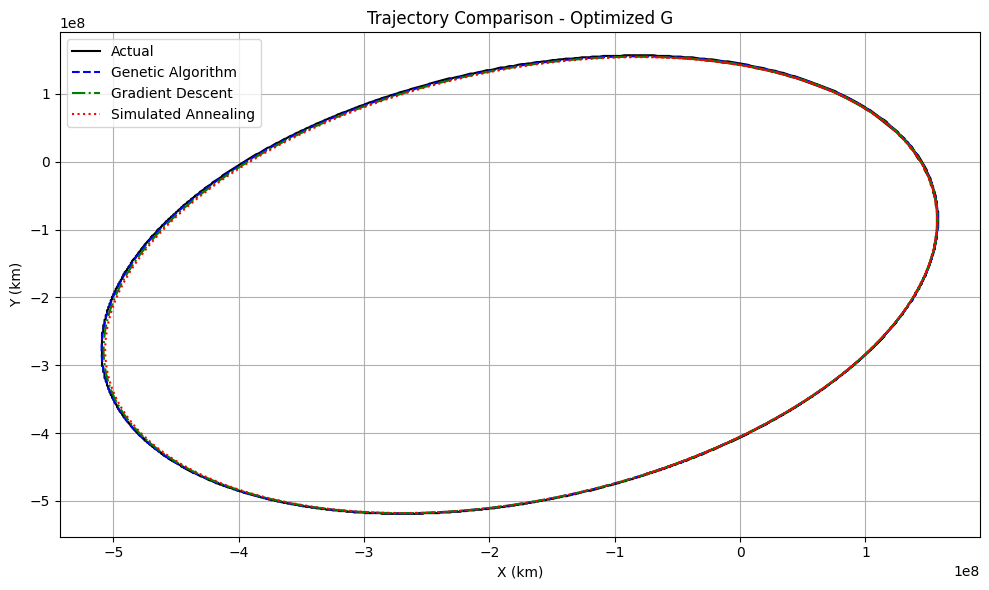

Optimization Summary:
                Method   Optimized G           MSE
0    Genetic Algorithm  6.654518e-20  2.443909e+12
1     Gradient Descent  6.674300e-20  2.337926e+13
2  Simulated Annealing  6.690384e-20  7.131534e+13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize, dual_annealing

# Loading and preprocessing data
df = pd.read_csv('/content/horizons_results 1.csv', skiprows=1)
df.columns = ['JDTDB', 'Date', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']
df = df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ']].apply(pd.to_numeric, errors='coerce').dropna()

positions = df[['X', 'Y', 'Z']].values
velocities = df[['VX', 'VY', 'VZ']].values

x0, y0, z0 = positions[0]
vx0, vy0, vz0 = velocities[0]
dt = 86400.0
n_steps = len(df)

G_true = 6.67430e-20
m_sun = 1.9885e30

# Simulation function
def simulate_orbit(G, x=x0, y=y0, z=z0, vx=vx0, vy=vy0, vz=vz0):
    traj = []
    for _ in range(n_steps):
        r = np.sqrt(x**2 + y**2 + z**2)
        ax = -G * m_sun * x / r**3
        ay = -G * m_sun * y / r**3
        az = -G * m_sun * z / r**3
        vx += ax * dt
        vy += ay * dt
        vz += az * dt
        x += vx * dt
        y += vy * dt
        z += vz * dt
        traj.append([x, y, z])
    return np.array(traj)

# Minimizing MSE between simulated and actual
def mse_loss(G):
    sim = simulate_orbit(G[0])
    return np.mean((positions - sim)**2)

# Optimization Techniques
bounds = [(6.65e-20, 6.70e-20)]

# 1. Genetic Algorithm
result_ga = differential_evolution(mse_loss, bounds)
sim_ga = simulate_orbit(result_ga.x[0])

# 2. Gradient Descent
result_gd = minimize(mse_loss, [G_true], method='L-BFGS-B', bounds=bounds)
sim_gd = simulate_orbit(result_gd.x[0])

# 3. Simulated Annealing
result_sa = dual_annealing(mse_loss, bounds)
sim_sa = simulate_orbit(result_sa.x[0])


plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], 'k', label='Actual')
plt.plot(sim_ga[:, 0], sim_ga[:, 1], 'b--', label='Genetic Algorithm')
plt.plot(sim_gd[:, 0], sim_gd[:, 1], 'g-.', label='Gradient Descent')
plt.plot(sim_sa[:, 0], sim_sa[:, 1], 'r:', label='Simulated Annealing')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Trajectory Comparison - Optimized G')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/content/task1_optimization_trajectory.png')
plt.show()


results_summary = {
    'Method': ['Genetic Algorithm', 'Gradient Descent', 'Simulated Annealing'],
    'Optimized G': [result_ga.x[0], result_gd.x[0], result_sa.x[0]],
    'MSE': [result_ga.fun, result_gd.fun, result_sa.fun]
}
df_results = pd.DataFrame(results_summary)
print("Optimization Summary:")
print(df_results)


✅ Mean Squared Error (XGBoost): 0.0566


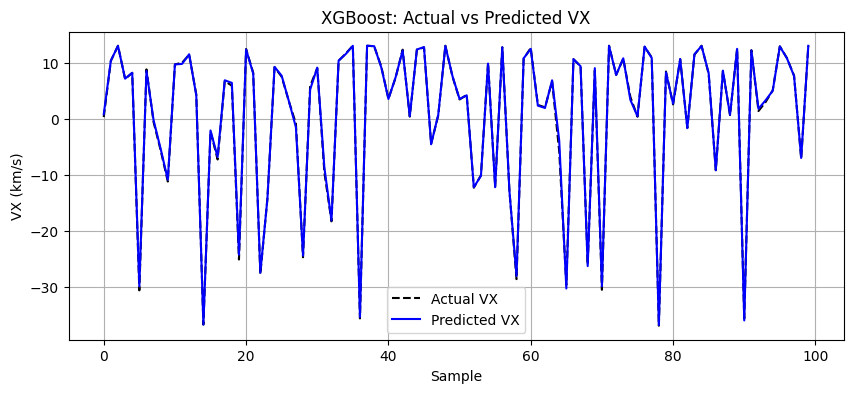

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('/content/horizons_results 1.csv', skiprows=1)
df.columns = ['JDTDB', 'Date', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']
df = df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ']].apply(pd.to_numeric, errors='coerce').dropna()

X = df[['X', 'Y', 'Z']].values
y = df[['VX', 'VY', 'VZ']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBRegressor(n_estimators=100, max_depth=3)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (XGBoost): {mse:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(y_test[:100, 0], label='Actual VX', linestyle='--', color='black')
plt.plot(y_pred[:100, 0], label='Predicted VX', linestyle='-', color='blue')
plt.title("XGBoost: Actual vs Predicted VX")
plt.xlabel("Sample")
plt.ylabel("VX (km/s)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.1 MB/s eta 0:00:00


[I 2025-06-09 04:44:41,819] A new study created in memory with name: no-name-e9004ebb-d9f5-4ed8-b4d4-9bd17104930a
[I 2025-06-09 04:44:43,764] Trial 0 finished with value: 0.027710299332087823 and parameters: {'max_depth': 4, 'learning_rate': 0.1631615590649254, 'n_estimators': 196}. Best is trial 0 with value: 0.027710299332087823.
[I 2025-06-09 04:44:44,961] Trial 1 finished with value: 0.023973888800976922 and parameters: {'max_depth': 4, 'learning_rate': 0.05839037519957755, 'n_estimators': 248}. Best is trial 1 with value: 0.023973888800976922.
[I 2025-06-09 04:44:45,767] Trial 2 finished with value: 0.026220465909563537 and parameters: {'max_depth': 4, 'learning_rate': 0.09570012929476093, 'n_estimators': 161}. Best is trial 1 with value: 0.023973888800976922.
[I 2025-06-09 04:44:46,191] Trial 3 finished with value: 0.02786531713705618 and parameters: {'max_depth': 4, 'learning_rate': 0.1363336171650453, 'n_estimators': 227}. Best is trial 1 with value: 0.023973888800976922.
[I 20

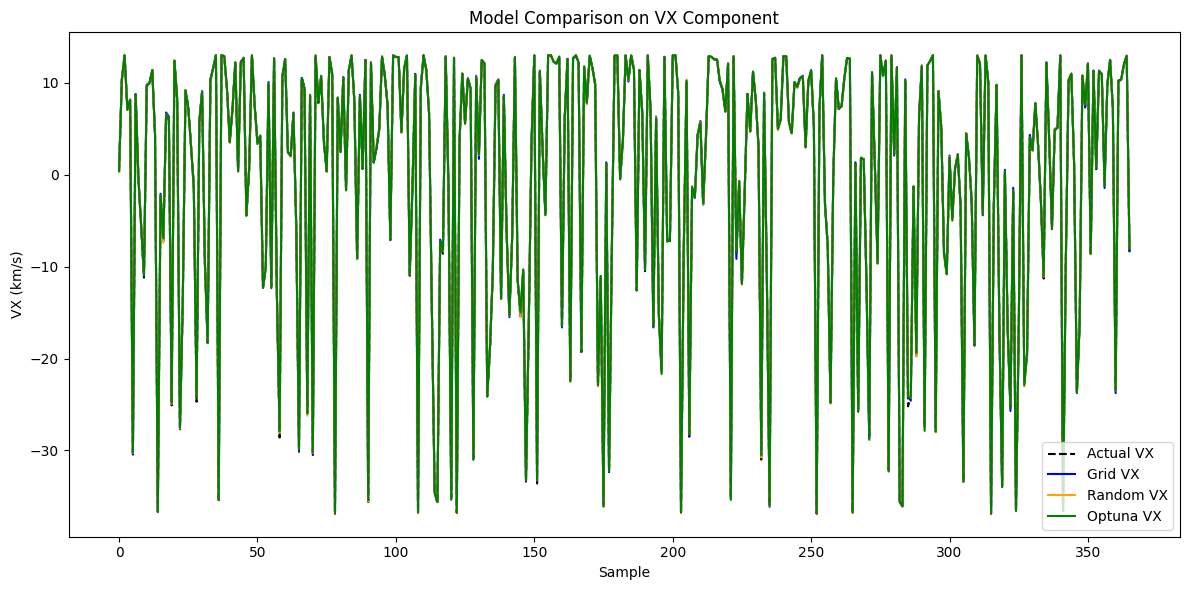

Mean Squared Errors (MSE):
Grid Search MSE      : 0.0460
Random Search MSE    : 0.0270
Bayesian (Optuna) MSE: 0.0240


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


df = pd.read_csv('/content/horizons_results 1.csv', skiprows=1)
df.columns = ['JDTDB', 'Date', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']
df = df[['X', 'Y', 'Z', 'VX']].apply(pd.to_numeric, errors='coerce').dropna()

X = df[['X', 'Y', 'Z']].values
y = df['VX'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


grid_params = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
grid = GridSearchCV(XGBRegressor(), grid_params, cv=3)
grid.fit(X_train, y_train)
grid_preds = grid.predict(X_test)
grid_mse = mean_squared_error(y_test, grid_preds)


rand_params = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200, 300]
}
rand = RandomizedSearchCV(XGBRegressor(), rand_params, cv=3, n_iter=5, random_state=42)
rand.fit(X_train, y_train)
rand_preds = rand.predict(X_test)
rand_mse = mean_squared_error(y_test, rand_preds)


def objective(trial):
    model = XGBRegressor(
        max_depth=trial.suggest_int('max_depth', 3, 6),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
opt_model = XGBRegressor(**study.best_params)
opt_model.fit(X_train, y_train)
opt_preds = opt_model.predict(X_test)
opt_mse = mean_squared_error(y_test, opt_preds)


plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, 'k--', label='Actual VX')
plt.plot(range(len(y_test)), grid_preds, 'b', label='Grid VX')
plt.plot(range(len(y_test)), rand_preds, 'orange', label='Random VX')
plt.plot(range(len(y_test)), opt_preds, 'green', label='Optuna VX')
plt.xlabel("Sample")
plt.ylabel("VX (km/s)")
plt.title("Model Comparison on VX Component")
plt.legend()
plt.tight_layout()
plt.savefig("/content/optimized_model_comparison_vx.png")
plt.show()

# === Step 6: Print MSEs ===
print(f"Mean Squared Errors (MSE):")
print(f"Grid Search MSE      : {grid_mse:.4f}")
print(f"Random Search MSE    : {rand_mse:.4f}")
print(f"Bayesian (Optuna) MSE: {opt_mse:.4f}")
